## **Word2Vec (CBOW, Skip-gram)**
1. 라이브러리를 활용하지 않고 CBOW, Skip-gram 모델을 각각 구현, 학습합니다.
3. gensim 라이브러리를 활용하여 CBOW, Skip-gram 모델을 학습하고 시각화합니다.

## **1. Word2Vec 구현 및 학습**

### 1.1 필요한 패키지 import

In [1]:
!pip install konlpy
!pip3 install tweepy==3.10.0 # 로컬(주피터)에서 실행할 때 필요... 4버전에서는 Error

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 36.8 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
from tqdm import tqdm
from konlpy.tag import Okt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### 1.2 Dataset 구축

Sample 데이터를 확인합니다.
데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [3]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

KoNLPy 패키지에서 제공하는 Twitter(Okt) tokenizer를 사용하여 tokenization합니다.

In [4]:
tokenizer = Okt()

In [5]:
def make_tokenized(data):
    tokenized = []
    for sent in tqdm(data):
        tokens = tokenizer.morphs(sent, stem=True)
        tokenized.append(tokens)

    return tokenized

In [6]:
train_tokenized = make_tokenized(train_data) 

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


tokenize된 데이터를 확인해봅시다. 

In [7]:
train_tokenized

[['정말', '맛있다', '.', '추천', '하다', '.'],
 ['기대하다', '것', '보단', '별로', '이다', '.'],
 ['다',
  '좋다',
  '가격',
  '이',
  '너무',
  '비싸다',
  '다시',
  '가다',
  '싶다',
  '생각',
  '이',
  '안',
  '드네',
  '요',
  '.'],
 ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'],
 ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'],
 ['위생',
  '상태',
  '가',
  '좀',
  '별로',
  '이다',
  '.',
  '좀',
  '더',
  '개선',
  '되다',
  '기르다',
  '바라다',
  '.'],
 ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'],
 ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'],
 ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'],
 ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

Tokenize 된 단어의 빈도 수를 확인할 수 있는 `word_count` 를 생성합니다.

In [8]:
word_count = defaultdict(int) #default값이 int인 딕셔너리, 값을 지정하지 않았다면 0으로 지정됨

for tokens in tqdm(train_tokenized):
    for token in tokens:
        word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 32288.71it/s]


가장 많이 등장한 토큰부터 적게 등장한 토큰 순으로 나열하여 `word_count` 를 확인해 봅니다.

In [9]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


각 단어를 정수 값(index) 에 mapping 하는 word to index (`w2i`) 를 생성합니다.

`w2i` 의 전체 크기는 고유한 단어의 개수(vocab size)와 동일합니다.

- 가장 많이 나온 단어가 정수 0, 적게 나온 단어가 정수 n을 부여받도록 해주세요.

In [11]:
w2i = {}
for pair in tqdm(word_count):
    ## TO DO (start) ##
    key, value = pair
    w2i[key] = len(w2i)
    ## TO DO (end) ##

100%|██████████| 60/60 [00:00<00:00, 267721.53it/s]


In [12]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

**Tip** `torch.utils.data.Dataset`


---
파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 Dataset과 DataLoader를 제공합니다.

이 도구를 활용하면 미니 배치 학습, 데이터 셔플, 병렬 처리를 간단히 수행할 수 있습니다. 

Dataset 를 정의하고 이를 DataLoader 에 전달함으로써 사용할 수 있습니다.

파이토치에서 제공하는 Dataset 을 커스텀하여 `CBOWDataset` 과 `SkipGramDataset` 을 정의해 봅시다.

`__init__`, `__len__`, `__getitem__` 을 다시 정의함으로써 커스텀할 수 있습니다.

출처: https://wikidocs.net/55580


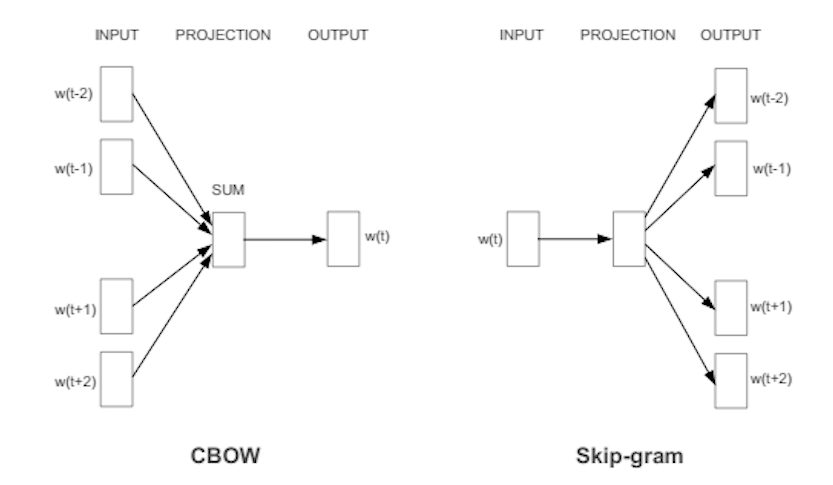

CBOW 는 window 내에 있는 context word를 가지고 target word 하나를 맞추는 과정에서 학습됩니다.

Skip-gram 은 target word 하나를 가지고 주변 context word 를 맞추는 과정에서 학습됩니다.

In [23]:
class CBOWDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2):
        self.x = []
        self.y = []
        
        ## TO DO (start) ##
        for tokens in train_tokenized:

        #1. token => integer (w2i)
            # token_ids = []
            # for token in tokens: 
            #     print(token, w2i[token]) # 글자, 숫자 형식으로 출력 
            
            token_ids = [w2i[token] for token in tokens] # list에 숫자 형식이지만 문장을 숫자로 표현한 것!

            #2. 중심단어, 주변단어 => list에 넣기 
            for i, id in enumerate(token_ids):
                # 2.1 중심단어가 될 수 있는지? 
                if i-window_size >=0 and i+window_size < len(token_ids):
                    self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
                    self.y.append(id) # 중심단어
        ## TO DO (end) ##

        # window_size = 2 # 중심단어를 기준으로 양옆으로 주변단어가 2만큼 있음을 가리킴 
        # ex) 나는 밥을 먹으며 학교에 갔다
        #     -2   -1   중심   1      2
        # (나는, 밥을, 학교에, 갔다) => 먹으며 (obow)
        # input     output    input     output
        # 먹으며 => 나,       먹으며 => 밥을, ... (skip-gram)

        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [24]:
cbow_set = CBOWDataset(train_tokenized)
print(list(cbow_set))

[(tensor([17, 18, 19, 10]), tensor(0)), (tensor([18,  0, 10,  0]), tensor(19)), (tensor([20, 21,  4,  2]), tensor(22)), (tensor([21, 22,  2,  0]), tensor(4)), (tensor([5, 3, 6, 7]), tensor(23)), (tensor([ 3, 23,  7, 24]), tensor(6)), (tensor([23,  6, 24, 25]), tensor(7)), (tensor([ 6,  7, 25, 26]), tensor(24)), (tensor([ 7, 24, 26, 27]), tensor(25)), (tensor([24, 25, 27, 28]), tensor(26)), (tensor([25, 26, 28,  6]), tensor(27)), (tensor([26, 27,  6, 29]), tensor(28)), (tensor([27, 28, 29, 30]), tensor(6)), (tensor([28,  6, 30, 31]), tensor(29)), (tensor([ 6, 29, 31,  0]), tensor(30)), (tensor([32, 33, 34, 35]), tensor(2)), (tensor([33,  2, 35, 11]), tensor(34)), (tensor([ 2, 34, 11, 36]), tensor(35)), (tensor([34, 35, 36, 37]), tensor(11)), (tensor([35, 11, 37,  0]), tensor(36)), (tensor([8, 1, 1, 5]), tensor(9)), (tensor([ 1,  9,  5, 38]), tensor(1)), (tensor([ 9,  1, 38,  0]), tensor(5)), (tensor([12, 39, 13,  4]), tensor(40)), (tensor([39, 40,  4,  2]), tensor(13)), (tensor([40, 13,

In [25]:
class SkipGramDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2):
        self.x = []
        self.y = []

        ## TO DO ##
        # start #
        #1. token => integer (w2i)
        for tokens in train_tokenized:
            token_ids = [w2i[token] for token in tokens]
        
            #2. 중심단어, 주변단어 => list에 넣기 
            for i, id in enumerate(token_ids):
                #2.1 중심 단어가 될 수 있는지
                if i-window_size >= 0 and i+window_size < len(token_ids):
                    for k in range(1, window_size + 1):
                        self.x.append(id)
                        self.y.append(token_ids[i-k])
                        self.x.append(id)
                        self.y.append(token_ids[i+k])

        #  end  #
        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [26]:
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

[(tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(17)), (tensor(0), tensor(10)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(20)), (tensor(22), tensor(2)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(0)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(5)), (tensor(23), tensor(7)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(24)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(25)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(26)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(27)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tens

### 1.3 모델 Class 구현

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


**Tip** `nn.Embedding` 


---


위에서 단어(토큰)을 고유한 정수 값으로 매핑하기 위해 정의한 `w2i` 를 떠올려 봅시다. <br>
입력 시퀀스의 단어를 모델의 입력으로 사용하기 위해서는,

1. `w2i` 를 이용해 각 단어를 고유한 정수 값으로 인코딩합니다.
2. 인코딩된 정수 시퀀스를 임베딩 층에 통과시킵니다.
3. 입력 시퀀스의 길이와 동일한 개수의 임베딩 벡터를 얻습니다. <br>

`nn.Embedding` 은 전체 어휘 집합 개수의 임베딩 벡터들 가운데 각 단어의 인덱스에 해당한는 임베딩 벡터에 접근하는 lookup table 로써 2번을 할 수 있도록 해줍니다. 

임베딩 벡터는 훈련 과정에서 학습됩니다.



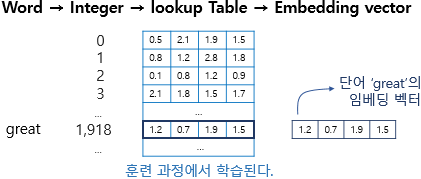

출처: https://wikidocs.net/64779

`nn.Embedding` 의 input 과 output 은 다음과 같습니다.


*   Input: (*), IntTensor or LongTensor of arbitrary shape containing the indices to extract
*   Output: (*, $H$), where * is the input shape and $H =\text{embediding_dim}$

```
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)
tensor([[[-0.0251, -1.6902,  0.7172],
         [-0.6431,  0.0748,  0.6969],
         [ 1.4970,  1.3448, -0.9685],
         [-0.3677, -2.7265, -0.1685]],

        [[ 1.4970,  1.3448, -0.9685],
         [ 0.4362, -0.4004,  0.9400],
         [-0.6431,  0.0748,  0.6969],
         [ 0.9124, -2.3616,  1.1151]]])
```



출처: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html



In [27]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[-0.1225, -0.4561, -0.0944],
         [ 0.6184, -0.7227,  0.4733],
         [-0.4701, -0.3504, -0.7816],
         [ 0.7665, -0.8624,  0.0586]],

        [[-0.4701, -0.3504, -0.7816],
         [ 0.0079,  0.0703, -1.2791],
         [ 0.6184, -0.7227,  0.4733],
         [-0.7642,  0.8410, -0.6049]]], grad_fn=<EmbeddingBackward0>)

In [47]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x):  # x: (B, 2W)
        
        ## TO DO ##
        # start #
        import pdb; pdb.set_trace() # 디버깅하기에 좋은 코드. 반드시 quit으로 종료할 것!

        # 1. embedding => 벡터 표현 얻기
        embeddings = self.embedding(x)

        # 2. 벡터들을 더해주기 
        embeddings = torch.sum(embeddings, dim = 1) # 뭐가 계산되는 건지 모르겠음... 

        # 3. linear layer 
        output = 1
        output = self.linear(embeddings)

        #  end  #
        
        return output

In [50]:
cbow_loader = DataLoader(cbow_set, batch_size=64)
sample_x, sample_y = next(iter(cbow_loader))
cbow = CBOW(vocab_size=len(w2i), dim=256)
cbow(sample_x)

tensor([[ 0.6564, -0.0482, -2.7063,  ...,  0.7023, -0.2786,  0.5073],
        [-1.4531, -0.6108, -0.6762,  ...,  1.9187, -0.9657, -0.9934],
        [ 0.8769, -0.3999,  2.6268,  ...,  2.5297,  0.2536,  1.1772],
        ...,
        [-0.9808,  0.1141, -0.5964,  ...,  1.3985, -0.0286, -0.4501],
        [ 1.3906,  1.1407,  0.2017,  ...,  0.4145, -0.6870,  0.6937],
        [-0.3912, -0.1771,  1.7479,  ...,  1.2702, -0.1554, -1.5811]],
       grad_fn=<AddmmBackward0>)

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x): # x: (B)

        ## TO DO ##
        # start #

        #  end  #
        
        return output

In [ ]:
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)
sample_x, sample_y = next(iter(skipgram_loader))
skipgram = SkipGram(vocab_size=len(w2i), dim=256)
skipgram(sample_x)

### 1.4 모델 학습 

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

**Tip** `torch.utils.data.DataLoader` 


---

Dataloader 는 앞서 정의한 Dataset 를 전달 받아 학습 과정에서 모델의 입력으로 사용할 수 있도록 데이터를 load 해줍니다. 

batch_size 를 정해줌으로써 미니 배치 학습이 가능한 형태로 데이터를 가공합니다.

예를 들어, 전체 데이터 수가 100 개 이고 batch size 가 20인 경우, 데이터는 20개의 데이터가 하나의 배치로 묶여 총 5개 의 배치로 구성됩니다.
즉, (100, ) 사이즈의 데이터가 (5, 20, ) 로 변하게 됩니다.

모델을 학습할 때에는 for loop 을 돌면서 한 iteration 에 하나의 배치를 데이터 로더로부터 전달 받아 모델의 입력으로 사용합니다.


```
# Example of DataLoader usage
for batch in data_loader:
    output = model(batch)
```


In [ ]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.


In [ ]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(cbow_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)
        output = cbow(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

다음으로 Skip-gram 모델 학습입니다.

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(skipgram_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)
        output = skipgram(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

### 1.5 테스트

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [ ]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = cbow.embedding(input_id)

    print(f"Word: {word}")
    print(emb.squeeze(0))

In [ ]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = skipgram.embedding(input_id)

    print(f"Word: {word}")
    print(max(emb.squeeze(0)))

## **2. gensim library 를 활용한 word2vec 학습 및 시각화**

### 2.1 필요한 패키지 import

In [3]:
# To ignore deprecated warnings
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  
import nltk
from nltk.corpus import movie_reviews # corpus 를 가져오는 용도 
from sklearn.manifold import TSNE # 시각화를 위한 TSNE 사용 
from sklearn.metrics import accuracy_score # accuracy score 를 계산하기 위한 metric 라이브러리 불러오기 
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from torch.utils import data # pytorch data class 
import torch.nn as nn # pytorch neural network 불러오기 
import torch.nn.utils.rnn as rnn_utils # rnn utils
import torch

import pickle

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### 2.2 Word embedding 학습

In [4]:
# 파라메터값 지정
num_features = 300 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 한 문장에 대한 최소 문자 수
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [5]:
from google.colab import drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [6]:
# preparing data
sentences = []
pos_data = open("/content/drive/MyDrive/Colab Notebooks/MNC_211229_실습자료/data/pos_train.txt").readlines()
neg_data = open("/content/drive/MyDrive/Colab Notebooks/MNC_211229_실습자료/data/neg_train.txt").readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(line.strip().split(' '))

In [7]:
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

# CBOW 모델 학습
CBOW = word2vec.Word2Vec(sentences,
                              sg = 0, # CBOW
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

2021-12-29 03:01:02,858 : INFO : collecting all words and their counts
2021-12-29 03:01:02,860 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-29 03:01:02,923 : INFO : PROGRESS: at sentence #10000, processed 239982 words, keeping 20149 word types
2021-12-29 03:01:02,982 : INFO : PROGRESS: at sentence #20000, processed 475267 words, keeping 28557 word types
2021-12-29 03:01:03,042 : INFO : PROGRESS: at sentence #30000, processed 718530 words, keeping 35153 word types
2021-12-29 03:01:03,098 : INFO : PROGRESS: at sentence #40000, processed 942659 words, keeping 40650 word types
2021-12-29 03:01:03,156 : INFO : PROGRESS: at sentence #50000, processed 1164181 words, keeping 45109 word types
2021-12-29 03:01:03,221 : INFO : PROGRESS: at sentence #60000, processed 1387734 words, keeping 49141 word types
2021-12-29 03:01:03,242 : INFO : collected 50290 word types from a corpus of 1453943 raw words and 62966 sentences
2021-12-29 03:01:03,243 : INFO : Loading 

### 2.3 학습한 embedding 확인 및 시각화


특정 단어와 유사한 의미를 가지는 단어를 추출해 봄으로써 임베딩에 단어의 의미가 잘 학습되었는지 확인합니다.

In [8]:
skip_gram.wv.most_similar("man") # skip-gram 모델을 이용하여 'man'에 가장 유사한 단어 추출

2021-12-29 03:04:28,875 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.7336576581001282),
 ('girl', 0.7070496082305908),
 ('boy', 0.6989223957061768),
 ('guy', 0.6823610067367554),
 ('teenager', 0.6741095185279846),
 ('person', 0.6699596643447876),
 ('lady', 0.6619805693626404),
 ('doctor', 0.6603778004646301),
 ('kid', 0.6558791995048523),
 ('einstein', 0.646325409412384)]

In [9]:
CBOW.wv.most_similar("man") # CBOW 모델을 이용하여 'man'에 가장 유사한 단어 추출

2021-12-29 03:04:34,290 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.9407865405082703),
 ('girl', 0.902518630027771),
 ('boy', 0.8719085454940796),
 ('child', 0.8131122589111328),
 ('kid', 0.8082699775695801),
 ('guy', 0.7721493244171143),
 ('secret', 0.7716439962387085),
 ('doctor', 0.7633424997329712),
 ('lawyer', 0.7610162496566772),
 ('person', 0.7581700086593628)]

300차원의 단어 임베딩을 2차원으로 차원 축소하여 시각화함으로써 임베딩 벡터의 분포를 확인해 봅니다.

**Tip** `t-SNE` 


---

t-SNE 는 차원 축소 (dimensionality reduction)와 시각화(visualization) 방법입니다.

Stochastic Neighboring Embedding(SNE) 라는 고차원 공간에 존재하는 데이터 $x$의 이웃 간의 거리를 최대한 보존하는 저차원의 $y$를 학습하는 방법입니다.

고차원 공간에서 특정 개체 $x_i$ 가 주어졌을 때 이웃 객체 $x_j$ 가 선택될 확률을 $p_{j|i}$, 저차원 공간에서 특정 개체 $y_i$ 가 주어졌을 때 이웃 객체 $y_j$ 가 선택될 확률을 $q_{j|i}$ 라고 한다면 SNE 는 $p$ 와 $q$의 분포 차이를 최대한 작게 함으로써 학습됩니다. 

두 확률분포의 유사도는 Kullback-Leibler divergence 라는 지표를 활용합니다.

SNE 는 가우시안 분포를 전제하는데, 가우시안 분포가 아닌 t분포를 가정하는 것이 t-SNE입니다.

출처: https://ratsgo.github.io/machine%20learning/2017/04/28/tSNE/

In [10]:
def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에대해 단어 labeling

    plt.show()

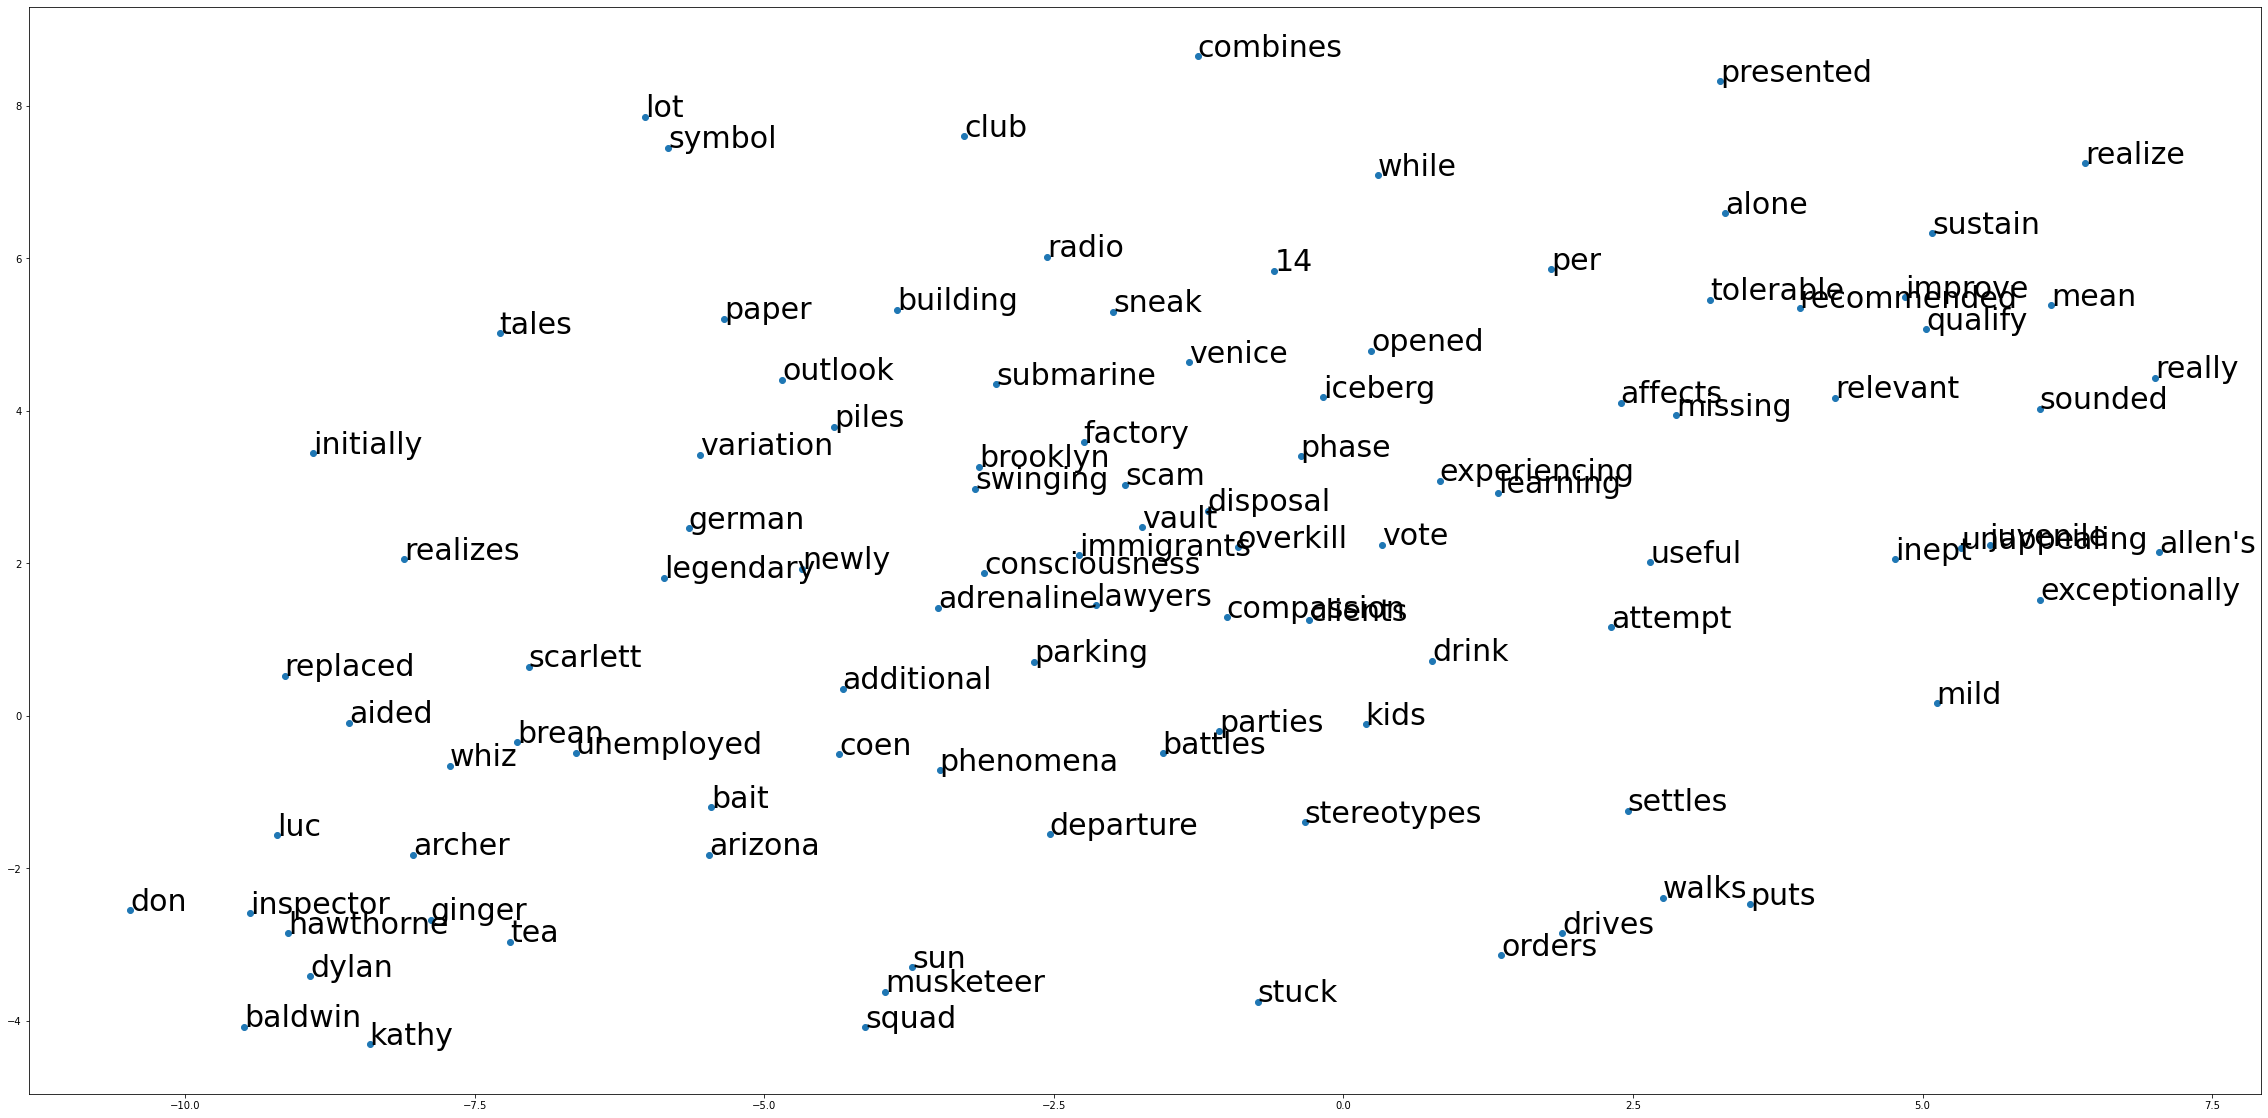

In [11]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

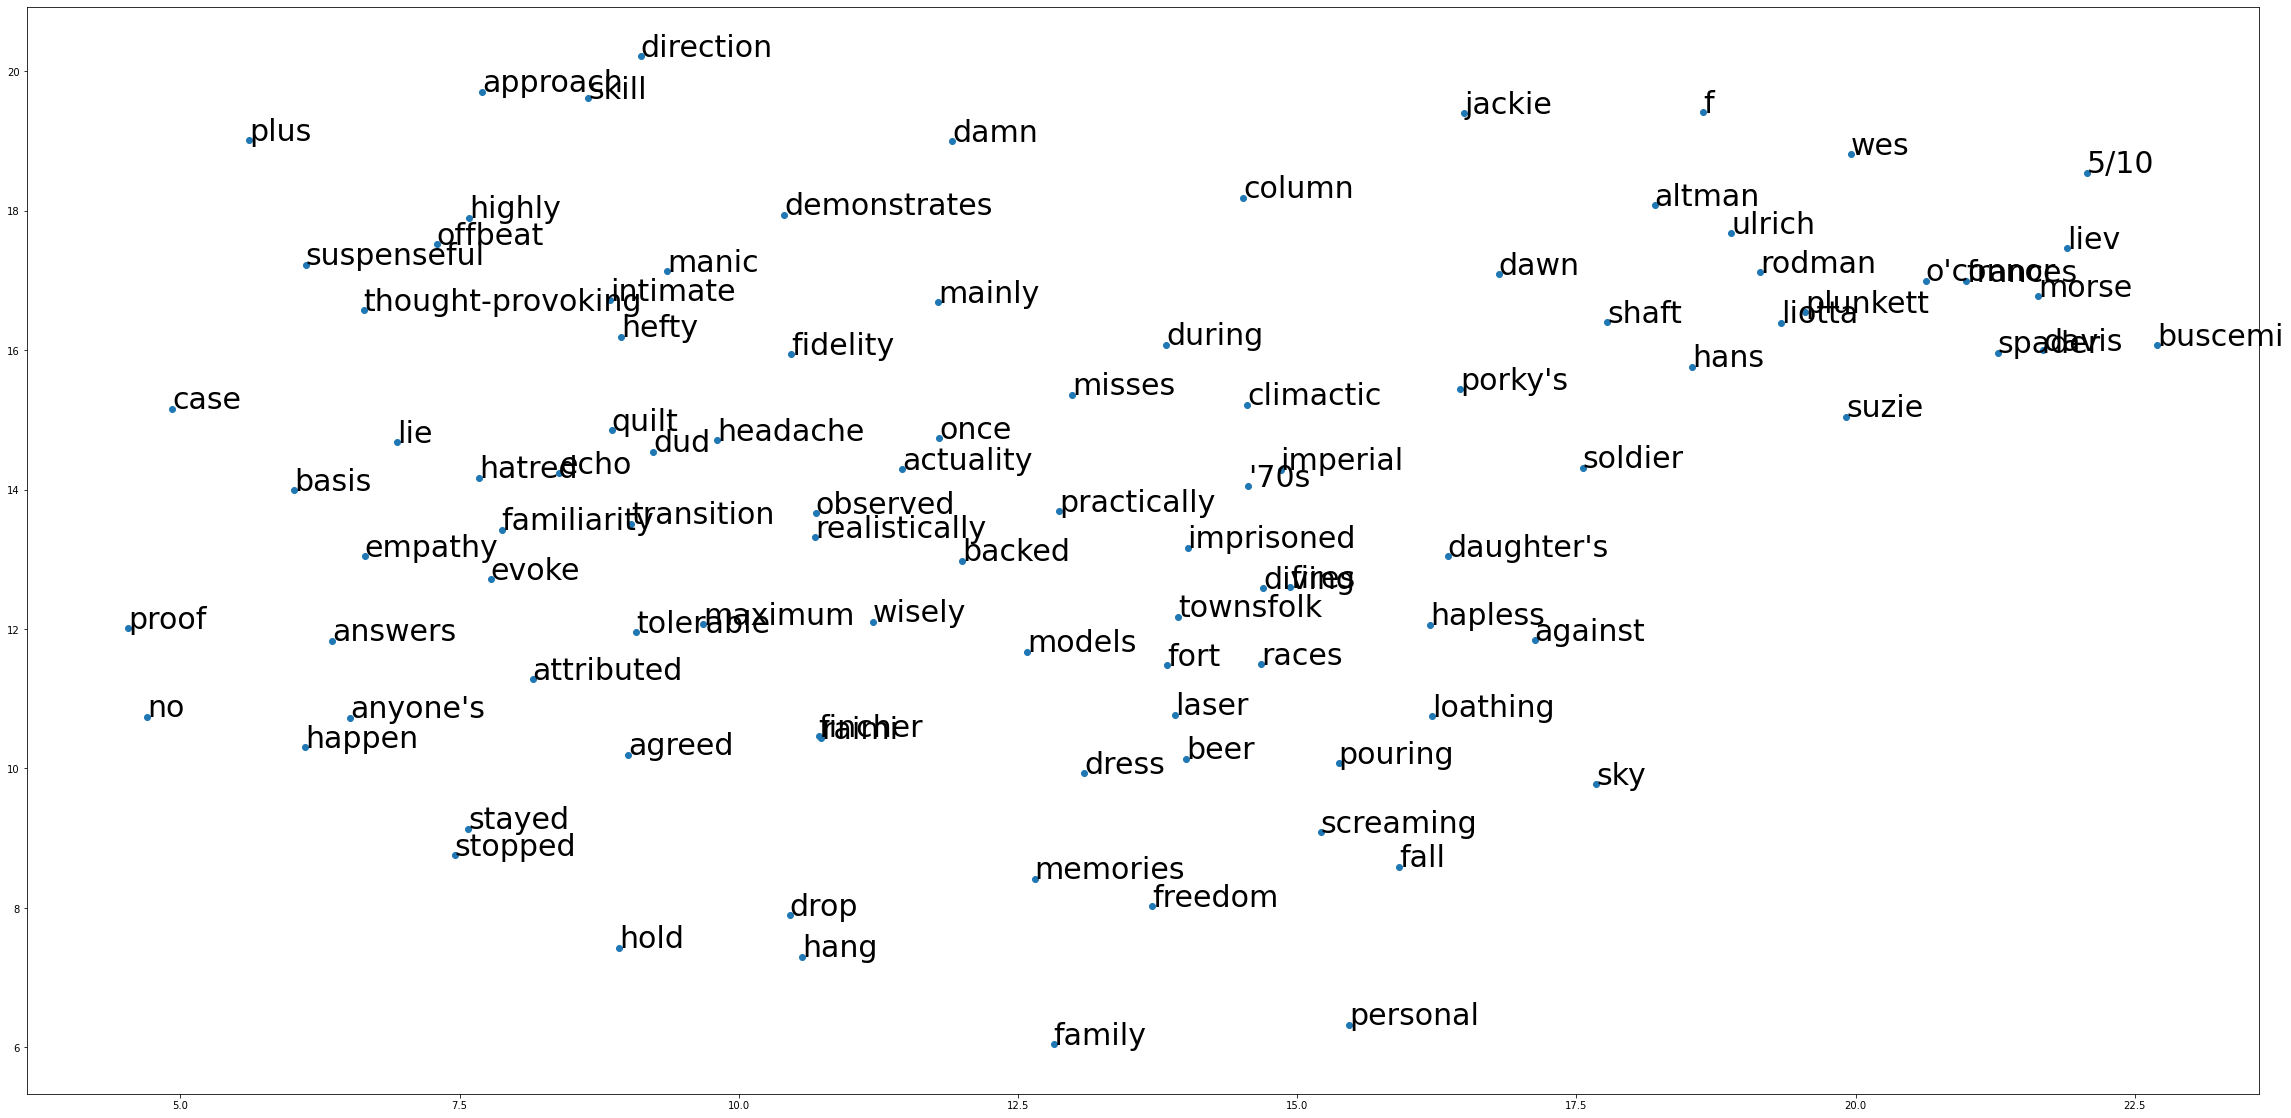

In [12]:
# CBOW 시각화(TSNE)
vocab = list(CBOW.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화